## Introduction

This notebook is designed to simulate real-world data that you could see from our technology. 

---


You have been hired by the company and are working with a US retail customer on a pilot deployment.  They are using our technology to track their merchandise throughout their supply chain.  The flow of their supply is:

*   **DC 1:**  Orders are filled and palletized.
*   **Truck:** Pallets travel from the DC 1 to DC 2 via semi-truck.
*   **DC 2:**  Pallets are unloaded, and additional merchandise may be added.  They are then reloaded onto a new truck.
*   **Truck:** Pallets travel from DC 2 to the Store.
*   **Store:** Pallets are unloaded, cases are removed, and stocked, and the empty cases are left behind the building awaiting pickup. 


## Part 0: Imports

Import necessary packages and 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import seaborn as sns

In [36]:
# Import Dataset

df = pd.read_excel('tote_shipment.xlsx')

In [37]:
#Look at the first few columns of the dataset
df.head()

,asset_type,asset_id,tag_id,Site,Zone,device_id,time_est,lat,lng,Temperature_C,Temperature_F
0,tote,102,(01)00850027865010(21)0082T0932,DC 1,pallet_assembly_DC1,F96E864E4F18,2022-08-02 11:57:38.044,47.79158,-65.68902,22.5,72.5
1,tote,102,(01)00850027865010(21)0082T0932,DC 1,pallet_assembly_DC1,F96E864E4F18,2022-08-02 12:00:57.803,47.79158,-65.68902,22.5,72.5
2,tote,102,(01)00850027865010(21)0082T0932,DC 1,pallet_assembly_DC1,F96E864E4F18,2022-08-02 12:06:46.752,47.79158,-65.68902,22.5,72.5
3,tote,102,(01)00850027865010(21)0082T0932,DC 1,pallet_assembly_DC1,F96E864E4F18,2022-08-02 12:08:19.072,47.79158,-65.68902,22.5,72.5
4,tote,102,(01)00850027865010(21)0082T0932,DC 1,pallet_assembly_DC1,F96E864E4F18,2022-08-02 12:09:58.231,47.79158,-65.68902,22.5,72.5


### Dataset Overview

* Site:  A large space that could contain multiple readers. Ex: DC 1.
* Zone:  Point of interest. These represent areas in which repeaters are installed. These can be thought of as sub-zones.  Ex: Dock Doors.
* Asset ID: The unique ID of the asset.
* Asset Type: The type of thing that is detected (ie tote).
* Device ID: The unique gateway reader ID that detected the device in the zone (there can be multiple in one zone).
* Time est: The time in EST.
* Lon: Longituge
* Lat: Latitude
* Temperature_C / F: Temperature in Celsius, Fahrentheit

## PART 1: Data Overview

* How many unique cases were we tracking throughout this pilot?
* What is the relationship between asset to tag? 
* What are the unique Sites we could see? 
* How many Zones are in each Site?
* What is the relationship between site and zone?


In [4]:
#Unique cases in the "asset_id" column
unique_cases = df['asset_id'].nunique()
print("Number of unique cases:", unique_cases)

Number of unique cases: 18


In [5]:
#examining the unique values in the "asset_type" and "tag_id" columns to understand their relationship
asset_tag_relationship = df.groupby(['asset_type', 'tag_id']).size().reset_index(name='count')
print("Asset to Tag relationship:")
print(asset_tag_relationship)

Asset to Tag relationship:
   asset_type                           tag_id  count
0        tote  (01)00850027865010(21)0082T0005   1861
1        tote  (01)00850027865010(21)0082T0017   6239
2        tote  (01)00850027865010(21)0082T0040   3250
3        tote  (01)00850027865010(21)0082T0117   3441
4        tote  (01)00850027865010(21)0082T0186   3867
5        tote  (01)00850027865010(21)0082T0193   6385
6        tote  (01)00850027865010(21)0082T0194   5437
7        tote  (01)00850027865010(21)0082T0196   3348
8        tote  (01)00850027865010(21)0082T0197   3260
9        tote  (01)00850027865010(21)0082T0219   3348
10       tote  (01)00850027865010(21)0082T0236   4714
11       tote  (01)00850027865010(21)0082T0260   3450
12       tote  (01)00850027865010(21)0082T0261   2899
13       tote  (01)00850027865010(21)0082T0329   3922
14       tote  (01)00850027865010(21)0082T0407   2504
15       tote  (01)00850027865010(21)0082T0415   4656
16       tote  (01)00850027865010(21)0082T0458   1444
1

In [6]:
#Unique sites in the dataset
unique_sites = df['Site'].unique()
print("Unique Sites:")
print(unique_sites)

Unique Sites:
['DC 1' 'Transit' 'DC 2' 'Store']


In [7]:
#Zones in each site by grouping the 'Site' column and counting the unique zones
zones_per_site = df.groupby('Site')['Zone'].nunique().reset_index(name='num_zones')
print("Number of Zones in each Site:")
print(zones_per_site)

Number of Zones in each Site:
      Site  num_zones
0     DC 1          5
1     DC 2          2
2    Store          4
3  Transit          4


In [8]:
#Relationship between Site and Zone using use the groupby() function on the columns and counting the number of occurrences
site_zone_relationship = df.groupby(['Site', 'Zone']).size().reset_index(name='count')
print("Site to Zone relationship:")
print(site_zone_relationship) #The relationship between site and zone indicates the distribution of zones within each site. It shows the number of occurrences (count) for each combination of site and zone.

Site to Zone relationship:
       Site                 Zone  count
0      DC 1        Forklift1_DC1     31
1      DC 1        Forklift3_DC1     75
2      DC 1       dock_doors_DC1    122
3      DC 1  pallet_assembly_DC1    455
4      DC 1          staging_DC1    592
5      DC 2       dock_doors_DC2   1554
6      DC 2          staging_DC2     97
7     Store  point_of_sale_Store     78
8     Store      receiving_Store  66099
9     Store     store_back_Store  27041
10    Store    store_front_Store   3679
11  Transit      PhoneKit1Bridge  14676
12  Transit          PhoneKit1GW     89
13  Transit      PhoneKit2Bridge  14604
14  Transit          PhoneKit2GW    869


* What is the temperature range we see? 
* Where is temperature the highest and lowest?

In [9]:
#Temperature Range 

#Celsius 
min_temp = df['Temperature_C'].min()
max_temp = df['Temperature_C'].max()
print("Temperature Range (Celsius):", min_temp, "to", max_temp)

#Fahrenheit 
min_temp = df['Temperature_F'].min()
max_temp = df['Temperature_F'].max()
print("Temperature Range (Fahrenheit):", min_temp, "to", max_temp)

Temperature Range (Celsius): 19.0 to 44.0
Temperature Range (Fahrenheit): 66.2 to 111.2


In [10]:
#Highest and Lowest temperature in Celsius for location
 
max_temp_row = df.loc[df['Temperature_C'].idxmax()]
max_temp_site = max_temp_row['Site']
max_temp_zone = max_temp_row['Zone']
print("Location with the highest temperature:")
print("Site:", max_temp_site)
print("Zone:", max_temp_zone)

min_temp_row = df.loc[df['Temperature_C'].idxmin()]
min_temp_site = min_temp_row['Site']
min_temp_zone = min_temp_row['Zone']
print("Location with the lowest temperature:")
print("Site:", min_temp_site)
print("Zone:", min_temp_zone)

Location with the highest temperature:
Site: Store
Zone: receiving_Store
Location with the lowest temperature:
Site: Store
Zone: store_back_Store


In [11]:
#Highest and Lowest temperature in Fahrenheit for location
 
max_temp_row = df.loc[df['Temperature_F'].idxmax()]
max_temp_site = max_temp_row['Site']
max_temp_zone = max_temp_row['Zone']
print("Location with the highest temperature:")
print("Site:", max_temp_site)
print("Zone:", max_temp_zone)

min_temp_row = df.loc[df['Temperature_F'].idxmin()]
min_temp_site = min_temp_row['Site']
min_temp_zone = min_temp_row['Zone']
print("Location with the lowest temperature:")
print("Site:", min_temp_site)
print("Zone:", min_temp_zone)

Location with the highest temperature:
Site: Store
Zone: receiving_Store
Location with the lowest temperature:
Site: Store
Zone: store_back_Store


## Part 2: The Journey of a Case

* Create a visualization that shows where a case was at over time at the zone or POI level. Imagine that this would be included in your presentation to the customer. (Non techical audience)

In [12]:
#Choosing a Random Case ID
unique_case_ids = df['asset_id'].unique()
print(unique_case_ids)

[102 145 149 159 167 170 181 182   2 200 205  37  52  58  59  62  70  84]


/var/folders/rd/9tqsrkxj25bdkzbjrzs0m1jm0000gp/T/ipykernel_5489/3535159277.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_data.sort_values('time_est', inplace=True)


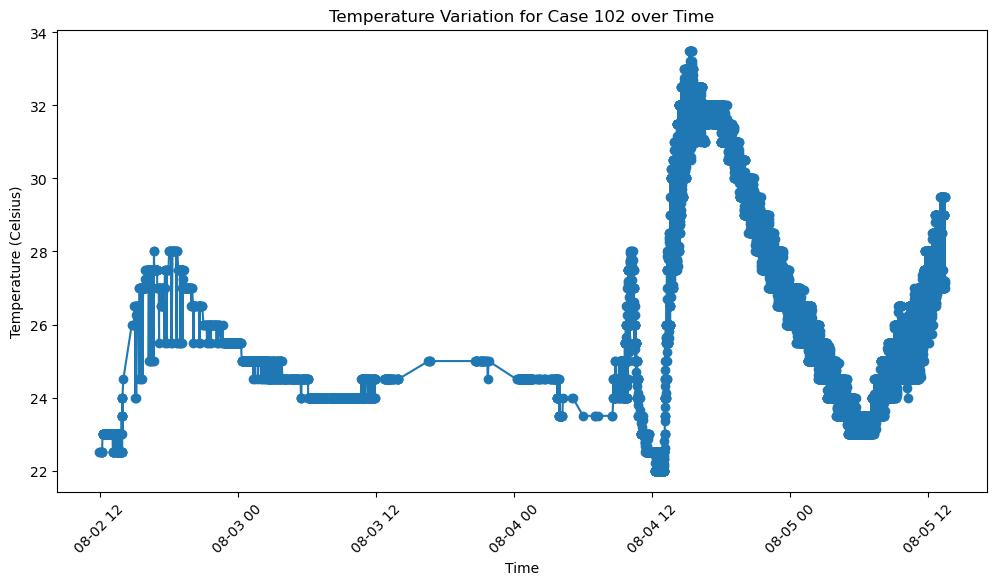

In [13]:
# Choosing a random Asset ID
case_id = '102'

# Converting the asset_id column to string type
df['asset_id'] = df['asset_id'].astype(str)

# Converting the case_id to lowercase for case insensitive search
case_id = case_id.lower()

# Filtering the dataset for the selected case ID (case-insensitive search)
case_data = df[df['asset_id'].str.lower() == case_id]

# Rechecking if the case ID exists in the dataset
if case_data.empty:
    print("Case ID not found in the dataset.")
else:
    # Checking if there are temperature values for the selected case ID
    if case_data['Temperature_C'].isnull().all():
        print("No temperature values available for the selected case ID.")
    else:
        # Checking if the time_est column is in datetime format
        if not pd.api.types.is_datetime64_any_dtype(case_data['time_est']):
            case_data['time_est'] = pd.to_datetime(case_data['time_est'])

        # Sorting the data by time_est column
        case_data.sort_values('time_est', inplace=True)

        # Creating a scatter plot showing the temperature over time
        plt.figure(figsize=(12, 6))
        plt.plot(case_data['time_est'], case_data['Temperature_C'], marker='o')

        # Setting labels and title
        plt.xlabel('Time')
        plt.ylabel('Temperature (Celsius)')
        plt.title('Temperature Variation for Case {} over Time'.format(case_id))

        # Rotating x-axis labels if needed
        plt.xticks(rotation=45)

        # Show plot
        plt.show()


* Visualize how the temperatue changes over time along its journey.  Imagine that this would be included in your presentation to the customer. (Non techical audience) 

/var/folders/rd/9tqsrkxj25bdkzbjrzs0m1jm0000gp/T/ipykernel_5489/1080373051.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_data.sort_values('time_est', inplace=True)


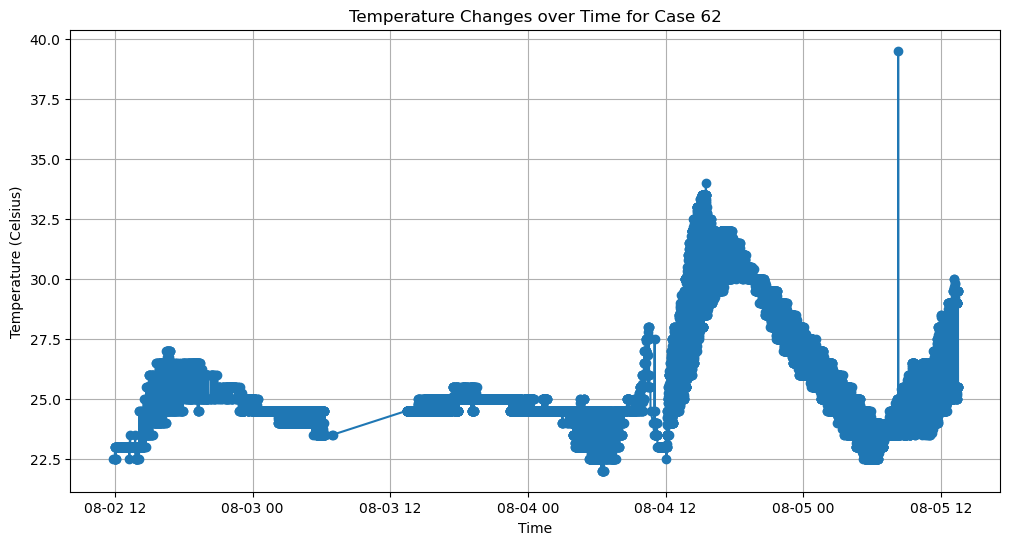

In [14]:
# Choosing a random asset ID
case_id = '62'

# Repeating all steps as above
df['asset_id'] = df['asset_id'].astype(str)


case_id = case_id.lower()


case_data = df[df['asset_id'].str.lower() == case_id]


if case_data.empty:
    print("Case ID not found in the dataset.")
else:
    if case_data['Temperature_C'].isnull().all():
        print("No temperature values available for the selected case ID.")
    else:
        if not pd.api.types.is_datetime64_any_dtype(case_data['time_est']):
            case_data['time_est'] = pd.to_datetime(case_data['time_est'])

        case_data.sort_values('time_est', inplace=True)

        plt.figure(figsize=(12, 6))
        plt.plot(case_data['time_est'], case_data['Temperature_C'], marker='o')

        plt.xlabel('Time')
        plt.ylabel('Temperature (Celsius)')
        plt.title('Temperature Changes over Time for Case {}'.format(case_id))
        plt.grid(True)
        plt.show()


* Visualize the lon lat data on a map to show how the case traveled.  You may incorporate any other additional information to make this more impactful. Imagine that this would be included in your presentation to the customer. (Non techical audience)

In [19]:
# Random asset ID
case_id = '102'

# Converting the asset_id column to string type
df['asset_id'] = df['asset_id'].astype(str)

# Converting the case_id to lowercase for case-insensitive search
case_id = case_id.lower()

# Filtering the dataset for the selected case ID (case-insensitive search)
case_data = df[df['asset_id'].str.lower() == case_id]

# Checking if the case ID exists in the dataset
if case_data.empty:
    print("Case ID not found in the dataset.")
else:
    # Filtering the data for latitude, longitude, site, and zone
    case_locations = case_data[['lat', 'lng', 'Site', 'Zone']].dropna()

    # Creating a map centered at the first location
    map_center = [case_locations['lat'].iloc[0], case_locations['lng'].iloc[0]]
    case_map = folium.Map(location=map_center, zoom_start=12)

    # Adding markers for each location with site and zone information
    for index, location in case_locations.iterrows():
        lat, lng, site, zone = location['lat'], location['lng'], location['Site'], location['Zone']
        folium.Marker([lat, lng], popup=f"Site: {site}<br>Zone: {zone}").add_to(case_map)

    # Saving the map as an HTML file
    case_map.save('case_map.html')
    print("Map visualization saved as 'case_map.html'. Please open the file in a web browser.")


Map visualization saved as 'case_map.html'. Please open the file in a web browser.


# Part 3: Customer Questions


The customer wants to understand the efficieny of ther DC operations.
* Based on what you see in the data, (all zones except for STORE), which parts of their operation are most & least "efficient?

In [20]:
# Filtering data for all zones except for STORE
dc_data = df[df['Zone'] != 'STORE']

# Calculating average time duration spent in each zone
zone_durations = dc_data.groupby('Zone')['time_est'].apply(lambda x: (x.max() - x.min()).total_seconds() / len(x))
zone_durations = zone_durations.reset_index(name='Average Duration')

# Sorting zones by average duration in ascending order
sorted_zones = zone_durations.sort_values('Average Duration')

print("Most Efficient Zones:")
print(sorted_zones.head(1))

print("\nLeast Efficient Zones:")
print(sorted_zones.tail(1))


Most Efficient Zones:
               Zone  Average Duration
10  receiving_Store          1.573303

Least Efficient Zones:
           Zone  Average Duration
12  staging_DC2       1049.334433


Most efficient zone is receiving_Store while the least efficient zone is staging_DC2.

The customer wants to understand the stocking efficiency in stores.
* Based on what you see in the data, how quickly did the store unload and stock the merchandise. 
* How could this be converted in a KPI that a regional manager could track? 

In [44]:
# Stocking efficiency in store

#Time spent unloading and stocking merchandise

store_data = df[df['Zone'] == 'Store']
store_data = store_data.sort_values(['asset_id', 'time_est'])
store_data['time_est_unix'] = store_data['time_est'].astype(int) // 10**9
store_data['stocking_time'] = (store_data.groupby('asset_id')['time_est_unix'].diff() / 60).astype(int)
average_stocking_time = store_data['stocking_time'].mean()
print(f"Average Stocking Time: {average_stocking_time} minutes")

Average Stocking Time: nan minutes


In [45]:
#Excluding values

store_data = df[df['Zone'] == 'Store']
store_data = store_data.sort_values(['asset_id', 'time_est'])
store_data['time_est_unix'] = store_data['time_est'].astype(int) // 10**9
store_data['stocking_time'] = (store_data.groupby('asset_id')['time_est_unix'].diff() / 60).astype(int)
average_stocking_time = store_data['stocking_time'].mean(skipna=True)
print(f"Average Stocking Time: {average_stocking_time} minutes")

Average Stocking Time: nan minutes


In [46]:
store_data = df[df['Zone'] == 'Store']
store_data = store_data.sort_values(['asset_id', 'time_est'])
store_data['time_est_unix'] = store_data['time_est'].astype(int) // 10**9
store_data['stocking_time'] = (store_data.groupby('asset_id')['time_est_unix'].diff() / 60).astype(int)
print(store_data)

average_stocking_time = store_data['stocking_time'].mean(skipna=True)

print(f"Average Stocking Time: {average_stocking_time} minutes")


Empty DataFrame
Columns: [asset_type, asset_id, tag_id, Site, Zone, device_id, time_est, lat, lng, Temperature_C, Temperature_F, time_est_unix, stocking_time]
Index: []
Average Stocking Time: nan minutes


In [47]:
store_data = df[df['Zone'] == 'Store']
stocking_time_grouped = store_data.groupby('asset_id')['time_est'].agg(lambda x: (x.max() - x.min()).total_seconds() / 60)
average_stocking_time = stocking_time_grouped.mean()
print(f"Average Stocking Time: {average_stocking_time} minutes")

Average Stocking Time: NaT minutes


In [48]:
store_data = df[df['Zone'] == 'Store']
store_data = store_data.sort_values(['asset_id', 'time_est'])
print(store_data)

store_data['stocking_time'] = store_data.groupby('asset_id')['time_est'].transform(lambda x: (x.max() - x.min()).total_seconds() / 60)
print(store_data)

average_stocking_time = store_data['stocking_time'].mean(skipna=True)
print(f"Average Stocking Time: {average_stocking_time} minutes")

Empty DataFrame
Columns: [asset_type, asset_id, tag_id, Site, Zone, device_id, time_est, lat, lng, Temperature_C, Temperature_F]
Index: []
Empty DataFrame
Columns: [asset_type, asset_id, tag_id, Site, Zone, device_id, time_est, lat, lng, Temperature_C, Temperature_F, stocking_time]
Index: []
Average Stocking Time: nan minutes


In [49]:
store_data = df[df['Zone'] == 'Store']
print(f"Number of rows in store_data: {len(store_data)}")

store_data = store_data.sort_values(['asset_id', 'time_est'])
print(store_data)

store_data['stocking_time'] = store_data.groupby('asset_id')['time_est'].transform(lambda x: (x.max() - x.min()).total_seconds() / 60)
print(store_data)

average_stocking_time = store_data['stocking_time'].mean(skipna=True)
print(f"Average Stocking Time: {average_stocking_time} minutes")


Number of rows in store_data: 0
Empty DataFrame
Columns: [asset_type, asset_id, tag_id, Site, Zone, device_id, time_est, lat, lng, Temperature_C, Temperature_F]
Index: []
Empty DataFrame
Columns: [asset_type, asset_id, tag_id, Site, Zone, device_id, time_est, lat, lng, Temperature_C, Temperature_F, stocking_time]
Index: []
Average Stocking Time: nan minutes


In [39]:
unique_zones = df['Zone'].unique()
print(unique_zones)

['pallet_assembly_DC1' 'Forklift1_DC1' 'staging_DC1' 'Forklift3_DC1'
 'dock_doors_DC1' 'PhoneKit2Bridge' 'PhoneKit1Bridge' 'PhoneKit2GW'
 'dock_doors_DC2' 'PhoneKit1GW' 'receiving_Store' 'store_back_Store'
 'store_front_Store' 'point_of_sale_Store' 'staging_DC2']


In [40]:
missing_values = store_data['time_est'].isna().sum()
print("Number of missing values in 'time_est':", missing_values)

Number of missing values in 'time_est': 0


In [41]:
print("Data type of 'time_est':", store_data['time_est'].dtype)
print("Data type of 'Zone':", store_data['Zone'].dtype)

Data type of 'time_est': datetime64[ns]
Data type of 'Zone': object


In [42]:
unique_zones = store_data['Zone'].unique()
print(unique_zones)

[]


In [43]:
unique_sites = store_data['Site'].unique()
print(unique_sites)

[]


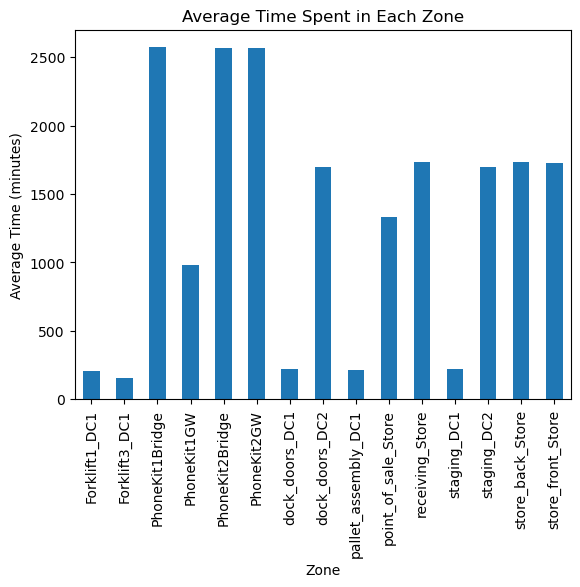

In [55]:
# Average time spent in each zone
average_time_per_zone = df.groupby('Zone')['time_est'].apply(lambda x: (x.max() - x.min()).total_seconds() / 60)
average_time_per_zone.plot(kind='bar')
plt.xlabel('Zone')
plt.ylabel('Average Time (minutes)')
plt.title('Average Time Spent in Each Zone')
plt.show()

'Zone' and 'Site' columns are showing up as empty for some reason which is why I am getting NaN and NaT. 

The KPI for tracking could be Average Stocking Time (as a metric) which is basically how long it takes to unload and stock each asset in the store and then calculating the average of these time durations across all assets in the store. This metric can then give an overview of the efficiency of the process. The regional manager could also set a benchmark for this metric and write an automated code to measure the duration against the benchmark and perhaps give a rating of 'good', 'bad', 'poor', 'excellent'. An example of calculating average time across each zone is given above in a visualization and can be replicated with new numbers and different zones. 

Please explain what you would ask for and what you will do with this data, given that you can talk with the following people:
* a.	Your implementation/hardware engineer (those who can add functionalities to your product)
* b.	The customer

* a. Implementation/Hardware Engineer:
I would discuss the insights and potential improvements identified in the data with the engineer. I would ask for their expertise in implementing additional functionalities or enhancements to the product based on the data analysis. For example, if we noticed that certain zones have higher temperature variations, I might inquire about the possibility of integrating temperature control mechanisms in those zones to ensure optimal conditions for the assets. Additionally, if there are specific asset movement patterns that could be optimized, I would discuss potential hardware modifications or adjustments to improve efficiency.

* b. The Customer:
When discussing the additional insights with the customer, I would highlight the key findings and their implications for their operations. I would present visualizations and data-driven insights that provide a deeper understanding of the store performance amongst other relevant insights. This could include highlighting zones with high and low asset utilization rates, identifying areas where stocking time is longer, showcasing temperature variations across different zones, and etc.

Furthermore, I would emphasize the potential business impact of these insights and recommend actionable steps for the customer. For example, if there are inefficient stocking processes in certain zones, I would suggest reevaluating staffing or resource allocation to improve efficiency. If temperature variations are causing issues, I might propose implementing better temperature monitoring systems or optimizing the placement of temperature-sensitive products.

Overall, the goal would be to collaborate with both the implementation/hardware engineer and the customer to leverage the insights in order to drive improvements, enhance operational efficiency, and ultimately deliver a better customer experience/satisfaction.

## Part 4: Bonus Insights

The customer is open to hearing about additional insights you found in the data above and beyond what they asked for.
* Based on what you can see in the data, are there any other interesting insights that the customer may want to hear about?



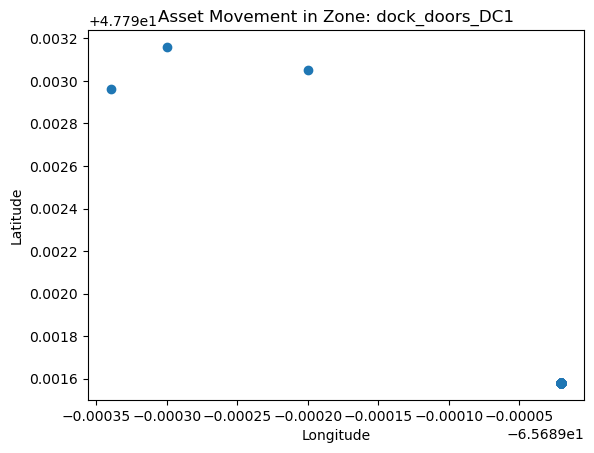

In [50]:
#The customer may want to hear about the movement patterns of the assets and understanding the most common routes, example:

zone = 'dock_doors_DC1'
zone_data = df[df['Zone'] == zone]
plt.scatter(zone_data['lng'], zone_data['lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Asset Movement in Zone: {zone}')
plt.show()


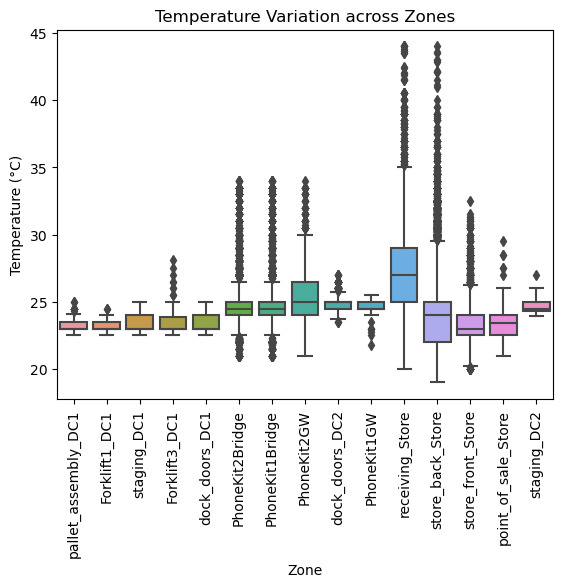

In [51]:
#Temperature can be an important factor to understand. Different ranges of the temperature in zones and how consistent or inconsistent these temperatures are. 

sns.boxplot(x='Zone', y='Temperature_C', data=df)
plt.xticks(rotation=90)
plt.xlabel('Zone')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation across Zones')
plt.show()

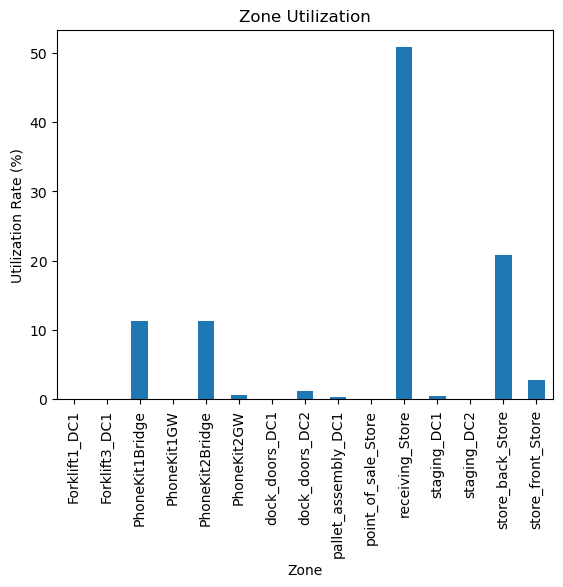

In [54]:
# Looking at how much each zone is utitlized as a percentage. 
zone_utilization = df.groupby('Zone')['asset_id'].count() / len(df) * 100
zone_utilization.plot(kind='bar')
plt.xlabel('Zone')
plt.ylabel('Utilization Rate (%)')
plt.title('Zone Utilization')
plt.show()

While there are many insights to be derived from the data, due to time constraint I have come up with 3 for now. 

1. The customer may be interested in knowing the movement patterns of the various assets to understand the most common routes. This can be further analyzed by getting insights on the time of each of the routes and finding the most efficient routes.

2. The customer may want to understand the temperature ranges. If the assest is one that can be impacted by the temperature then adjusting the temperature or changing the zone accordingly can be good for business. 

3. Looking at zone utilization can also help customers re-plan certain routes or asset storage to avoid over-crowding or under utilization of existing resources. 
